# Battleship Solitaire'i lahendaja

## Idee
Tegemist on lihtsa tehisintellektiga, mis lahendab pildi pealt Battleship Solitaire'i. Selle kasutamiseks lae üles pilt ning tehisintellekt lahendab selle su eest ära.

Hetkeseisuga saab mäng aru lehest https://www.puzzle-battleships.com/

## Autorid
Oliver Savolainen, Märt Tender, Kaur Vali

## Kasutatud funktsionaalsed blokid
- Pildituvastus, et selgitada ära hetkesed positsioonid.
- Lihtne reegite alusel intellekt, mis lahendab tabeli seisu.

## Impordid

In [1]:
## Importid piltide jaoks
import cv2 as cv
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

## Pildituvastus osa

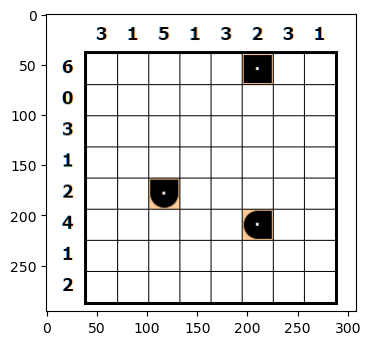

In [2]:
#Loe pilt
img_rgb = cv.imread('images/puzzle8.PNG')
# Mustvalge igaks juhuks
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)

In [3]:
#meetod matchTemplate kasutades ruutude asukohtade leidmiseks
#iga erineva ruudu kohta on 5 versiooni template, et kindlasti kõik ruudud üles leida ja vältida, millegi mitte nägemist
#puzzle_rgb-pilt, templateFile - template, mida kasutatakse, version - versioon kaustas
# allFound - järjend, kus kõik asukohad kirjas
def findTemplate(puzzle_rgb,templateFile,version,allFound):
    template = cv.imread('images/' + 'square'+templateFile+'/' + version + '.PNG')
    templates = []
    #lisame template 4 erinevat pidi, et kõikvõimalikud leitakse
    templates.append(template)
    templates.append(cv.rotate(template, cv.ROTATE_90_COUNTERCLOCKWISE))
    templates.append(cv.rotate(template, cv.ROTATE_90_CLOCKWISE))
    templates.append(cv.rotate(template, cv.ROTATE_180))
    w, h = template.shape[::-2]
    for i in range(len(templates)):
        res = cv.matchTemplate(puzzle_rgb,templates[i], cv.TM_CCOEFF_NORMED)
        #0.96 hetkel maksimaalne threshold, mis leiab pea alati mingi versiooni lauast
        # kõrgema korral enamasti mingeid ruutusid ei leia, madalama korral merd ja tühja ruutu tihti ei eristata
        threshold = 0.96
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            alreadyThere = False
            for found in allFound:
                #iga leitud asukoha korral kontrollime ega tegemist pole juba leitud ruuduga
                if abs(found[0] - pt[0]) < 10 and abs(found[1]-pt[1]) < 10:
                    alreadyThere = True
                    break
            if not alreadyThere:
                #kui pole varem leitud ruut, lisame vastavalt nimele selle allFoundi
                #'None' template ehk hetkel tühi ruut on None tüüpi
                if templateFile == 'None':
                    allFound.append((pt[0],pt[1],None))
                #2 korral ehk poolringi taolisel ruudul on 4 erinevat varianti, nii et anname vastavalt järjekorrale õige variandi
                elif templateFile == '2':
                    allFound.append((pt[0],pt[1],int(templateFile)*(i+1)))
                else:
                    allFound.append((pt[0],pt[1],int(templateFile)))
                # rectangle(pilt, algusnurk (koordinaadid), lõppnurk, värv (BGR), joone paksus)
                cv.rectangle(puzzle_rgb, pt, (pt[0]+w, pt[1]+h), (0,255,255), 1)

In [4]:
#meetod kõikide ruutude leidmiseks ja kontrolliks, kas järjendi pikkus on ruut (siin maksimaalne 15x15, aga saab lihtsalt muuta)
def getPuzzle(img_rgb):
    allFound = []
    templates = ['0','2','1','5','None']
    for template in templates:
        for i in range(1,6):
            img_copy = img_rgb.copy()
            findTemplate(img_copy,template,'Version' + str(i),allFound)
    for i in range(1,16):
        if len(allFound) == i**2 or len(allFound) + 1 == i**2:
            return allFound
    return None

In [5]:
# meetod asukohtade sorteerimiseks ja seejärel rea ja veeru kaupa täpsustamiseks asukohta, et ühtlased read ja veerud saada
#kasutatakse nii numbrite kui ka ruutude jaoks
def levelRowsAndColumns(allFound):
    #kõigepealt samade y-de saamine
    sortedSquares = sorted(allFound, key=lambda element: (element[1]))
    for i in range(len(sortedSquares)):
        #kui väike vahe, siis peab olema tegelt sama veeru omad, saab ühtlustada
        if 0 < sortedSquares[i][1] - sortedSquares[i-1][1] < 20:
            sortedSquares[i] = (sortedSquares[i][0],sortedSquares[i-1][1],sortedSquares[i][2])
    #siis x-d
    sortedSquares = sorted(sortedSquares, key=lambda element: (element[0]))
    for i in range(len(sortedSquares)):
        #kui väike vahe, siis peab olema tegelt sama rea omad
        if 0 < sortedSquares[i][0] - sortedSquares[i-1][0] < 20:
            sortedSquares[i] = (sortedSquares[i-1][0],sortedSquares[i][1],sortedSquares[i][2])
    sortedSquares = sorted(sortedSquares, key=lambda element: (element[1],element[0]))
    return sortedSquares

In [6]:
#kui pikkus 1 võrra ruudust lühem, leiame selle asukoha ja lisame järjendisse tühja ruuduna
#võib tekitada probleeme, kui tegelikult seal asukohas pole tühi ruut, aga üldiselt peaks töökindlamaks tegema programmi
def fixMissingOne(allFound):

    counts_x = {}
    counts_y = {}
    #leiame x-de ja y-de esinemiste arvud
    for t in allFound:
        if t[0] in counts_x:
            counts_x[t[0]] += 1
        else:
            counts_x[t[0]] = 1

        if t[1] in counts_y:
            counts_y[t[1]] += 1
        else:
            counts_y[t[1]] = 1
    #leiame minimaalse x esinemise ja kõik selle x-ga elemendid        
    min_count_x = min(counts_x.values())
    
    outliers_x = [k for k, v in counts_x.items() if v == min_count_x]
    
    #sama y-ga
    min_count_y = min(counts_y.values())

    outliers_y = [k for k, v in counts_y.items() if v == min_count_y]
    
    #kui sellist x ja y on 1 esineb neid teistest 1 võrra vähem, võime lisada selle ruudu, muidu on midagi vigast
    if min_count_x + 1 == max(counts_x.values()) and min_count_y + 1 == max(counts_y.values()) and len(outliers_x) == 1 and len(outliers_y) == 1:
        allFound.append((outliers_x[0],outliers_y[0],None))
        allFound = sorted(allFound, key=lambda element: (element[1],element[0]))
        return allFound
    
    return None

In [7]:
#lõplikusse järjendite järjendisse viimine
def coordinatesToArray(allFound):
    if allFound is None:
        return
    length = len(allFound)
    correct = None
    #fikseerime numbrid
    allFound = levelRowsAndColumns(allFound)
    #leiame rea suuruse
    rowLength = -1
    for i in range(1,16):
        #kui pikkus on arvu ruut, on reapikkus leitud
        if length == i**2:
            rowLength = i
            break
        #kui üks puudu, proovime lisada tühja ruudu
        if length + 1 == i**2:
            allFound = fixMissingOne(allFound)
            if  allFound is not None:
                rowLength = i
                break
            else:
                return None
    if rowLength == -1:
        return None
    fullMatrix = []
    #viime ridadesse vastava reapikkuse kaupa
    for i in range(rowLength):
        row = [t[2] for t in allFound[i*rowLength:i*rowLength+rowLength]]
        fullMatrix.append(row)
    return fullMatrix

In [8]:
#leiame templatede abil veergude ja ridade täidetud ruutude arvud
def findNumbers(img):
    allNumbers = []
    #0-9 templated on olemas, kuigi suuremaid numbreid kui 8 pea kunagi ei esine
    for i in range(10):
        #kõik sarnane nagu ruutudega
        template = cv.imread('images/numbers/' + str(i) + '.PNG')
        res = cv.matchTemplate(img,template, cv.TM_CCOEFF_NORMED)
        threshold = 0.9
        loc = np.where(res >= threshold)
        w, h = template.shape[::-2]
        for pt in zip(*loc[::-1]):
            alreadyThere = False
            for found in allNumbers:
                if abs(found[0] - pt[0]) < 10 and abs(found[1]-pt[1]) < 10:
                    alreadyThere = True
                    break
            if not alreadyThere:
                allNumbers.append((pt[0],pt[1],i))
    #teeme jälle asukohad ühtlaseks
    allNumbers = levelRowsAndColumns(allNumbers)
    #esimene pool y ja siis x järgi sorteerides peab olema veergudele (up), teine ridadele (side)
    up = [x[2] for x in allNumbers[:int(len(allNumbers)/2)]]
    side = [x[2] for x in allNumbers[int(len(allNumbers)/2):]]
    return up,side

## Mängu lahendamise osa

Lahendab reeglite põhjal mängulaua

### Algväärtused, mida on vaja jooksutamiseks:
Need on väärtustatud mängimise sektsioonis
* dim - mänguvälju küljepikkus
* field - mänguväli (dim x dim maatriks), kus:
    * None on tühjus
    * 1, 2, 4, 5, 6, 8 tähistavad eri kujuga laevatükke
    * 0 tähistab vett
* up - laevade kogused veergudes
* side - laevade kogused ridades
* largest - kõige pikema laeva pikkus

In [9]:
# kui mingil real või veerul peab olema null laeva, siis teeme vastavalt terve rea või veeru mereks
def zeros(index, row=False):
    global field, up, side, dim
    
    if row and side[index] == 0:
        for i in range(dim):
            set_sea(i, index)
        
    elif not row and up[index] == 0:
        for i in range(dim):
            set_sea(index, i)

In [10]:
# koordinaadil (x,y) oleva ruudu muutmine mereks juhul,
# kui sealne koht on veel täitmata ja see koht on mänguvälja piirides
def set_sea(x, y):
    global field, dim, change
    
    if 0 <= x < dim and 0 <= y < dim and field[y][x] is None:
        change = True
        field[y][x] = 0

        
# koordinaadil (x,y) oleva ruudu muutmine laevaks juhul,
# kui sealne koht on veel täitmata ja see koht on mänguvälja piirides
def set_ship(x, y):
    global field, dim, change
    
    if 0 <= x < dim and 0 <= y < dim and field[y][x] is None:
        change = True
        # arv 3 tähistab geneerilist laevatükki ehk tüki kuju on teadamta
        field[y][x] = 3

        
# muudame lavatükke ümbritsevad ruudud mereks ja väärtuste 2, 4, 6, 8 puhul sisestame ka kõrvaloleva laevatüki
def sides_sea(x, y):
    global field, dim
    
    point = field[y][x]
    
    if point:
        # nurgad on meri sõltumata tüki kujust
        corners = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        for corr_x, corr_y in corners:
            set_sea(x + corr_x, y + corr_y)
        
        # millised küljed on meri sõltub laevatüki kujust
        if point == 1:
            set_sea(x, y - 1)
            set_sea(x - 1, y)
            set_sea(x + 1, y)
            set_sea(x, y + 1)
        elif point == 2:
            set_sea(x, y - 1)
            set_ship(x, y + 1)
        elif point == 4:
            set_sea(x - 1, y)
            set_ship(x + 1, y)
        elif point == 6:
            set_sea(x + 1, y)
            set_ship(x - 1, y)
        elif point == 8:
            set_sea(x, y + 1)
            set_ship(x, y - 1)

In [11]:
# loe ära mitu laevatükki on vastavas reas või veerus
def count_ships(index, row=False):
    global field, dim
    
    count = 0
    
    if row:
        for i in range(dim):
            if field[index][i] not in [None, 0]:
                count += 1
    else:
        for i in range(dim):
            if field[i][index] not in [None, 0]:
                count += 1
                
    return count


# määra kõik tüjad kohad reas või veerus mereks
def all_sea(index, row=False):
    global field, up, side, dim
    
    ship_count = count_ships(index, row)
    
    if row:
        if ship_count == side[index]:
            for i in range(dim):
                set_sea(i, index)
    else:
        if ship_count == up[index]:
            for i in range(dim):
                set_sea(index, i)

In [12]:
# loe ära mitu meretükki on vastavas reas või veerus
def count_sea(index, row=False):
    global field, dim
    
    count = 0
    
    if row:
        count = field[index].count(0)
    else:
        for i in range(dim):
            if field[i][index] == 0:
                count += 1
                
    return count
        

# määra kõik tüjad kohad reas või veerus laevadeks
def all_ship(index, row=False):
    global field, up, side, dim
    
    sea_count = count_sea(index, row)
    
    if row:
        if sea_count == dim - side[index]:
            for i in range(dim):
                set_ship(i, index)
    else:
        if sea_count == dim - up[index]:
            for i in range(dim):
                set_ship(index, i)

In [13]:
# kõntrolli kas koordinaat (x,y) on mänguväljalt maas OR kas seal asub meri
def sea_or_off(x, y):
    global field, dim
    
    return x < 0 or x >= dim or y < 0 or y >= dim or field[y][x] == 0


# meetod, et juhul kui koordinaadil (x,y) asub laevatükk väärtusega 5, 
# siis kuidaspidiselt seda sisaldav laev mänguväljal paikneb
# ning vastavalt paigutab kõrvalolevad laevatükid
def fives(x, y):
    global field, dim
    
    point = field[y][x]
    
    if point == 5:
        if sea_or_off(x + 1, y) or sea_or_off(x - 1, y):
            set_ship(x, y + 1)
            set_ship(x, y - 1)
        elif sea_or_off(x, y + 1) or sea_or_off(x, y - 1):
            set_ship(x + 1, y)
            set_ship(x - 1, y)

In [14]:
# kas koordinaadil (x,y) asub laevatükk
def check_ship(x, y):
    global field, dim
    
    return 0 <= x < dim and 0 <= y < dim and field[y][x] != 0


# abimeetod, et ilma erindit põhjustamata listist elemente eemaldada
def remove_if(arr, el):
    if el in arr:
        arr.remove(el)

        
# juhul kui koordinaadil (x,y) asub laevatükk väärtusega 3, siis võimaluse korral selgita välja laevatüki tegelik kuju
def fix(x, y):
    global field, dim, change
    
    if field[y][x] != 3:
        return
    
    surrounding = [
        (-1, -1), (-1, 0), (-1, 1), 
        (0, -1),  (0, 0),  (0, 1),
        (1, -1),  (1, 0),  (1, 1)
    ]
    
    # kontrollime et kõik ümbritsevad ruudud oleksid juba teada (ehk pole None), 
    # sest ainult siis on laevatüki kuju võimalik kindlalt teada
    for corr_x, corr_y in surrounding:
        if 0 <= y + corr_y < dim and 0 <= x + corr_x < dim and field[y + corr_y][x + corr_x] is None:
            return
        
    poss = [1, 2, 4, 6, 8]
    
    if check_ship(x, y - 1) and check_ship(x, y + 1) or check_ship(x - 1, y) and check_ship(x + 1, y):
        field[y][x] = 5
        return
    
    if check_ship(x, y - 1):
        remove_if(poss, 1)
        remove_if(poss, 2)
        remove_if(poss, 4)
        remove_if(poss, 6)
    if check_ship(x, y + 1):
        remove_if(poss, 1)
        remove_if(poss, 4)
        remove_if(poss, 6)
        remove_if(poss, 8)
    if check_ship(x - 1, y):
        remove_if(poss, 1)
        remove_if(poss, 2)
        remove_if(poss, 4)
        remove_if(poss, 8)
    if check_ship(x + 1, y):
        remove_if(poss, 1)
        remove_if(poss, 2)
        remove_if(poss, 6)
        remove_if(poss, 8)
    
    if sea_or_off(x, y - 1):
        remove_if(poss, 8)
    if sea_or_off(x, y + 1):
        remove_if(poss, 2)
    if sea_or_off(x - 1, y):
        remove_if(poss, 6)
    if sea_or_off(x + 1, y):
        remove_if(poss, 4)
        
    if len(poss) != 1:
        # seda ei tohiks juhtuda
        print(poss)
        print(x, y)
        print_field()
        raise Exception("Võimalikke laevatüki kujusid on rohkem kui üks")
    
    field[y][x] = poss[0]

In [15]:
# mitu iga kujuga laeva on veel mänguväljale paigutamata
def ships_remaining():
    global field, dim
    
    ships = [s for s in ships_goal]
    
    for y in range(dim):
        for x in range(dim):
            point = field[y][x]
            
            if point == 1:
                ships[0] -= 1
            elif point == 2:
                size = 1 # actually size - 1
                while field[y + size][x] == 5:
                    size += 1
                    
                if field[y + size][x] == 8:
                    ships[size] -= 1
            elif point == 4:
                size = 1 # actually size - 1
                while field[y][x + size] == 5:
                    size += 1
                    
                if field[y][x + size] == 6:
                    ships[size] -= 1
                
    return ships

In [16]:
# mitmesse kohta mänguväljal mahuks antud suurusega laev
# mõistlik välja kutsuda ainult kõige suurema paigutamata laeva pikkusega
def fits_size(size):
    global field, dim
    
    total = 0
    
    for y in range(dim):
        c_none_1 = False
        length_1 = 0
        c_none_2 = False
        length_2 = 0
        for x in range(dim):
            if field[y][x] != 0:
                if field[y][x] is None:
                    c_none_1 = True
                length_1 += 1
            else:
                if length_1 >= size and c_none_1:
                    total += 1
                length_1 = 0
                c_none_1 = False
                
                
            if field[x][y] != 0:
                if field[x][y] is None:
                    c_none_2 = True
                length_2 += 1
            else:
                if length_2 >= size and c_none_2:
                    total += 1
                length_2 = 0
                c_none_2 = False
                
        if length_1 >= size and c_none_1:
            total += 1
        if length_2 >= size and c_none_2:
            total += 1
                
    return total

In [17]:
# abimeetod, fill_largest() meetodis kasutamiseks
# fill_largest() leiab koha, kuhu laev tuleb panna ja siis juhul, kui laev on horisontaalne, 
# kutsub välja käesoleva meetodi, et laev ja võimaluse korral otsdes olev meri, päriselt mälnguväljale panna
def fill_horizontal(c_x, c_y, size):
    global field, dim, change
    
    spot_len = c_x[1] - c_x[0] + 1
                    
    empty = spot_len - size

    for i_x in range(c_x[0] + empty, c_x[1] - empty + 1):
        set_ship(i_x, c_y)

    start_x = -1
    ship_len = 0
    for i_x in range(c_x[0], c_x[1] + 1):
        if field[c_y][i_x] is None:
            start_x = -1
        else:
            if start_x == -1:
                start_x = i_x
                ship_len = 0
            ship_len += 1

            if ship_len == size:
                if start_x != 0:
                    set_sea(start_x - 1, c_y)
                if i_x + 1 != dim:
                    set_sea(i_x + 1, c_y)
                break

# abimeetod, fill_largest() meetodis kasutamiseks
# fill_largest() leiab koha, kuhu laev tuleb panna ja siis juhul, kui laev on vertikaalne, 
# kutsub välja käesoleva meetodi, et laev ja võimaluse korral otsdes olev meri, päriselt mälnguväljale panna
def fill_vertical(c_x, c_y, size):
    global field, dim, change
    
    spot_len = c_y[1] - c_y[0] + 1
                    
    empty = spot_len - size

    for i_y in range(c_y[0] + empty, c_y[1] - empty + 1):
        set_ship(c_x, i_y)

    start_y = -1
    ship_len = 0
    for i_y in range(c_y[0], c_y[1] + 1):
        if field[i_y][c_x] is None:
            start_y = -1
        else:
            if start_y == -1:
                start_y = i_y
                ship_len = 0
            ship_len += 1

            if ship_len == size:
                if start_y != 0:
                    set_sea(c_x, start_y - 1)
                if i_y + 1 != dim:
                    set_sea(c_x, i_y + 1)
                break

                
# pane antud suurusega laev kõikidesse kohtadesse kuhu see veel mahub
# võib välja kutsuda ainult suurima paigutamata laeva suurusega ja ainult,
# kui seda suurmimat laeva on veel panemata sama palju kui on kohti, kuhu sellise pikkusega laev mahub
def fill_largest(size):
    global field, dim
    
    for y in range(dim):
        c_none_1 = False
        length_1 = 0
        c_none_2 = False
        length_2 = 0
        for x in range(dim):
            if field[y][x] != 0:
                if field[y][x] is None:
                    c_none_1 = True
                length_1 += 1
            else:
                if length_1 >= size and c_none_1:
                    c_y = y
                    c_x = (x - length_1, x - 1)
                    
                    fill_horizontal(c_x, c_y, size)
                    
                length_1 = 0
                c_none_1 = False
                
                
            if field[x][y] != 0:
                if field[x][y] is None:
                    c_none_2 = True
                length_2 += 1
            else:
                if length_2 >= size and c_none_2:
                    c_y = (x - length_2, x - 1)
                    c_x = y
                    
                    fill_vertical(c_x, c_y, size)
                    
                length_2 = 0
                c_none_2 = False
                
        if length_1 >= size and c_none_1:
            c_y = y
            c_x = (dim - 1 - length_1, dim - 1)

            fill_horizontal(c_x, c_y, size)
            
        if length_2 >= size and c_none_2:
            c_y = (dim - 1 - length_2, dim - 1)
            c_x = y

            fill_vertical(c_x, c_y, size)

In [18]:
# abimeetod väljaku printimiseks, kusjuures loetavuse huvides asendatakse None-id 7-tega
def print_field():
    global field
    
    for row in field:
        print([(x if x is not None else 7) for x in row])
    print("\n")
    

# reeglipõhise lahendamise põhimeetod
def rules():
    global change, dim, largest

    for y in range(dim):
        zeros(y)
        zeros(y, True)
    
    while True:
        change = False

        # põhireeglite rakendamine
        # osad reeglid käivad ridade ja veergude kohta, osad konkreetsete ruutude kohta
        for y in range(dim):
            all_sea(y)
            all_sea(y, True)
            all_ship(y)
            all_ship(y, True)

            for x in range(dim):
                fives(x, y)
                sides_sea(x, y)
                fix(x, y)
        
        largest_left = -1
        ships_left = ships_remaining()
        for i in range(largest):
            if ships_left[largest - 1 - i] != 0:
                largest_left = largest - i
                break
        
        if largest_left == -1:
            # siia jõudmine tähendab, et kõiki laevu on veel paigutada null tükki
            break
        
        largest_fits = fits_size(largest_left)
        
        # selle tingimuse kohta loe meetodi fill_largest() juurest
        if ships_left[largest_left - 1] == largest_fits:
            fill_largest(largest_left)
        
        if not change:
            # siia jõudmine tähendab, et laevu küll peaks veel paigutama, 
            # kuid kuna viimasel tsükli iteratsioonil ühtegi muutust ei tohimunud, 
            # ei oska ülejänud laevu reeglipõhine lahendaja paigutada
            break

## Mängimine

See on funktsioon, mille väljakutsumisega saab jooksutada kogu mängu ja saada tulemus

In [19]:
def prettifyPrint(table, row, column):
        
    strRow = [" "+str(x)+" " for x in row]
    strCol = [" "+str(x)+" " for x in column]
     
    # prettfy
    prettyTable = []
    for row in table:
        new_row = []
        for element in row:
            if element == None:
                new_row.append(" ")
            elif element == 0:
                new_row.append("~")
            elif element == 1:
                new_row.append("*")
            elif element == 2:
                new_row.append("^")
            elif element == 3:
                new_row.append("??")
            elif element == 4:
                new_row.append("<")
            elif element == 5:
                new_row.append("[]")
            elif element == 6:
                new_row.append(">")
            elif element == 8:
                new_row.append("v")
        prettyTable.append(new_row)
                    
    fig = plt.figure()
    ax = fig.add_subplot()
    
    the_table = plt.table(cellText = prettyTable,
                          colWidths=[0.04] * len(row),
                          rowLabels=strRow,
                          colLabels=strCol,
                          loc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(24)
    the_table.scale(4, 4)
    
    # Removing ticks and spines enables you to get the figure only with table
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    
    plt.show()

In [20]:
# mängimiseks vajalikud globaalsed muutujad, algväärtustame, kui seda välja jooksutada
dim = -1
largest = -1
field = []
up = []
side = []
ships_goal = []
# kas viimase tsükliiteratsiooni käigus tehti mänguväljal mõni muudatus
change = False

In [21]:
def reset():
    global change, field, up, side, dim, largest, ships_goal
    # mängimiseks vajalikud globaalsed muutujad, algväärtustame, kui seda välja jooksutada
    dim = -1
    largest = -1
    field = []
    up = []
    side = []
    ships_goal = []
    # kas viimase tsükliiteratsiooni käigus tehti mänguväljal mõni muudatus
    change = False

In [22]:
# See meetod mängib läbi mängu
# img_path - mängulauast pildi path
def play(img_path):
    reset()
    global change, field, up, side, dim, largest, ships_goal
    
    print("##################################")
    print("Alustame lahendamist!")
    
    # Loeme sisse pildi
    img_rgb = cv.imread(img_path)
    
    # Leia pusle
    puzzle = getPuzzle(img_rgb)
    
    if puzzle == None:
        print("Tekkis viga pildi tuvastamisel!")
        print("##################################")
        reset()
        return
    
    field = coordinatesToArray(puzzle)
    
    dim = len(field)
        
    # Leiame numbrid
    up, side = findNumbers(img_rgb)

    
    print("\nLeitud pusle:")    
    prettifyPrint(field, side, up)


    if dim == 6:
        largest = 3
    elif dim == 8 or dim == 10:
        largest = 4
    elif dim == 15:
        largest = 5
    elif dim == 20:
        largest = 7
    elif dim == 25:
        largest = 8
    elif dim == 30:
        largest = 9
    else:
        print("Tundmatu suurusega mängulaud!")
        print("##################################")
        reset()
        return
    
    # kui palju iga pikkusega laeva mänguväljal on
    # laevade pikkusega 1 kogus on largest
    # kõiki järgnevaid on ühe võrra vähem, kuni largest pikkuseni, milliseid laevu on 1
    ships_goal = [largest - i for i in range(largest)]
    
    ## Lahendamine ja tulemuse kuvamine
    rules()
    print("\nLahendatud tabel:")
    prettifyPrint(field, side, up)
    
    print("Lõpp!")
    print("##################################")
    reset()

## Näide 1

##################################
Alustame lahendamist!

Leitud pusle:


ValueError: 'rowLabels' must be of length 6

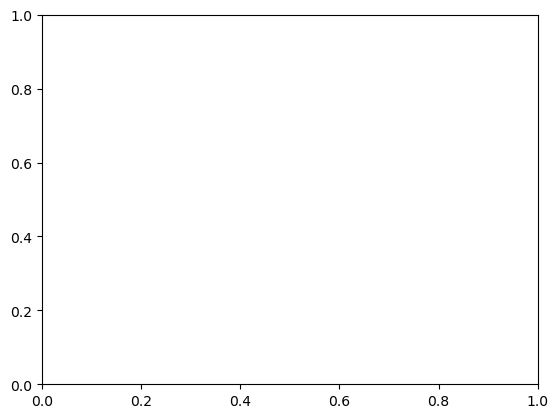

In [23]:
play("images/puzzle6.PNG")